# Customer Lifetime Value (CLV) estimators

**Authors :**
* Louiza AOUAOUCHE
* Salim ABDOU DAOURA

**DESCRIPTION:**

The project consists in studying basic estimators so as to predict the potential duration that a customer could live in a company before churning. We define it as its lifetime value. For that, we use two type of data :
* Not censored data : means that at the moment of the measure, all the durations are known
* Censored data (more realistic): means that, for some customers, the duration is unknown since they are still in the company. (Their lifetimes will be equal to their seniority values in the company - ancienneté in french)

We use estimators based on three distributions because of their similarity with the survival function:
* **[Geometric distribution](./geometric.ipynb)**
* **[Exponential distribution](./exponential.ipynb)**
* **[Pareto distribution](./pareto.ipynb)**

Once we studied the consistency of our estimators on randomly generated data, we apply the result on real data. For that we use a dataset from the package `sksurv.datasets` called `The Veterans’ Administration Lung Cancer Trial` which is a randomized trial of two treatment regimens for lung cancer. The data set (Kalbfleisch J. and Prentice R, (1980) The Statistical Analysis of Failure Time Data. New York: Wiley) consists of 137 patients and 8 variables, which are described below:

* **Treatment**: denotes the type of lung cancer treatment; standard and test drug.
* **Celltype**: denotes the type of cell involved; squamous, small cell, adeno, large.
* **Karnofsky_score**: is the Karnofsky score.
* **Diag**: is the time since diagnosis in months.
* **Age**: is the age in years.
* **Prior_Therapy**: denotes any prior therapy; none or yes.
* <span style="color:blue">**Status**</span>: denotes the status of the patient as dead or alive; dead or alive.
* <span style="color:blue">**Survival_in_days**</span>: is the survival time in days since the treatment.
([source](https://scikit-survival.readthedocs.io/en/stable/user_guide/00-introduction.html#The-Veterans%E2%80%99-Administration-Lung-Cancer-Trial))

Our interest is to study how our estimators act on this datasets. For this we only use `Survival_in_days` and `Status` features.

# Real data

In [2]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.interpolate as spi
import functions as f
from sksurv.datasets import load_veterans_lung_cancer

In [24]:
# PACKAGE
def plot_distribution(Y, title):
    sns.histplot(Y, color='gray', kde=False, stat='density', zorder=1)
    plt.xlabel("Durations (days)")
    plt.title(title)
    plt.ylabel("Probability Density")

def plot_interpolated_line(bin_midpoints, hist):
    spline = spi.splrep(bin_midpoints, hist)
    x = np.linspace(min(bin_midpoints), max(bin_midpoints), 100)
    y = spi.splev(x, spline)
    plt.plot(x, y, color='red', label='Real data distribution', zorder=2)

def plot_estimation(Y, status, estimator_name, theta, title):
    hist, bin_edges = np.histogram(Y, density=True)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    plot_distribution(Y, title)
    plot_interpolated_line(bin_midpoints, hist)

    # Compute the distribution values using the estimated parameter
    x = np.linspace(1, max(Y), len(Y))
    if estimator_name == "Exponential":
        dist = theta * np.exp(-theta * x)
        color = 'blue'
    elif estimator_name == "Pareto":
        x_m = 1
        dist = (theta * (x_m ** theta)) / (x ** (theta + 1))
        color = 'orange'
    else:
        raise ValueError("Invalid estimator name.")
    
    # Get the x-axis and y-axis limits from the distribution plot
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.plot(x, dist, color=color, label=f"Estimation - {estimator_name} (theta={theta:.2f})")
    # Restore the original x-axis and y-axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.show()
    
def plot_estimation2(Y, status, lower, upper, estimator_name, theta, title):
    hist, bin_edges = np.histogram(Y, density=True)
    bin_midpoints = (bin_edges[:-1] + bin_edges[1:]) / 2

    plot_distribution(Y, title)
    plot_interpolated_line(bin_midpoints, hist)

    # Compute the distribution values using the estimated parameter
    x = np.linspace(1, max(Y), len(Y))
    if estimator_name == "Exponential":
        dist = theta * np.exp(-theta * x)
        color = 'blue'
    elif estimator_name == "Pareto":
        x_m = 1
        dist = (theta * (x_m ** theta)) / (x ** (theta + 1))
        color = 'orange'
    else:
        raise ValueError("Invalid estimator name.")
    
    # Get the x-axis and y-axis limits from the distribution plot
    xlim = plt.xlim()
    ylim = plt.ylim()
    plt.plot(x, dist, color=color, label=f"Estimation - {estimator_name} (theta={theta:.2f})")
    plt.plot(x, theta * np.exp(-lower * x), color='green', linestyle='--', label="CI")
    plt.plot(x, theta * np.exp(-upper * x), color='green', linestyle='--')
    
    # Restore the original x-axis and y-axis limits
    plt.xlim(xlim)
    plt.ylim(ylim)
    plt.legend()
    plt.show()

def compare_estimators(Y, status, title):
    clv_geom_c_r = f.geom_c_clv_estimator2(Y, status)
    clv_exp_c_r = f.exp_c_clv_estimator2(Y, status)
    clv_pareto_c_r = f.pareto_c_clv_estimator2(Y, status)

    print("Estimator Comparison:")
    print("Geometric CLV Estimator:", clv_geom_c_r)
    print("Exponential CLV Estimator:", clv_exp_c_r)
    print("Pareto CLV Estimator:", clv_pareto_c_r)

    plot_estimation(Y, status, "Exponential", 1 / clv_exp_c_r, title)
    plot_estimation(Y, status, "Pareto", clv_pareto_c_r / (clv_pareto_c_r - 1), title)
    return clv_geom_c_r,clv_exp_c_r,clv_pareto_c_r

Estimator Comparison:
Geometric CLV Estimator: 130.1796875
Exponential CLV Estimator: 130.1796875
Pareto CLV Estimator: -0.29575575369714924


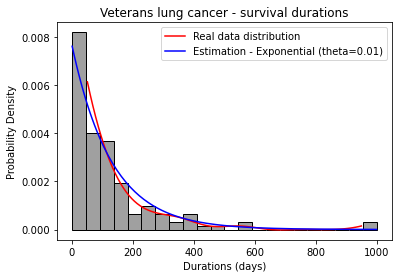

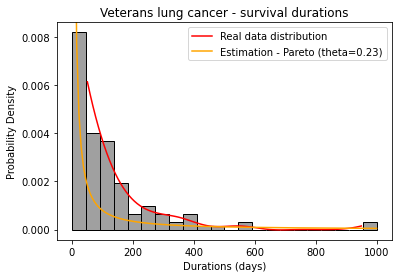

In [4]:
# Load the Veterans' Administration Lung Cancer Trial dataset
data_x, data_y = load_veterans_lung_cancer()
status = data_y['Status']
Y = data_y['Survival_in_days']
title = "Veterans lung cancer - survival durations"
clv_geom_c_r,clv_exp_c_r,clv_pareto_c_r = compare_estimators(Y, status, title)

We know that if a distribution’s tail is “too heavy”, then its mean will not exist. This justifies the incoherence of the average CLV value found with Pareto estimator $-0.29$. So, for this dataset the pareto distribution does not suit.

Meanwhile for exponential distribution, we observe a good fit to the data. We can compare the estimated value to the mean to measure the error.

In [5]:
y_mean = Y.mean()
print("Exponential estimator error: %.2f %%" %(abs(y_mean-clv_exp_c_r)/y_mean))

Exponential estimator error: 0.07 %


The error is less than $1\%$ so we conclude that the exponential estimator is suitable for this dataset.

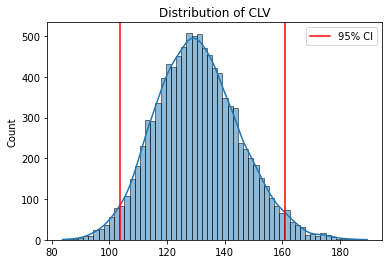

IC = [103.506949 , 160.890795 ] 


In [7]:
Y_n = []
Y_n.append(Y)
Y_n.append(status)
_,_ , clv_exp_real = f.bootstrap_samples(Y_n, 1, f.exp_c_clv_estimator2)
lower_exp_real, upper_exp_real  = f.CI_plot_95(clv_exp_real, 0.05)

The dataset contains values between $0$ and $1000$ days with a mean of $121$ days. Estimating the CLV gives us a CI of $[104 , 161]$ which is reprensed below.

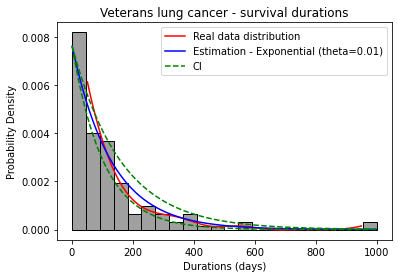

In [25]:
plot_estimation2(Y, status, 1/lower_exp_real, 1/upper_exp_real, "Exponential", 1 / clv_exp_c_r, title)